In [58]:
from pathlib import Path
from typing import Tuple, Callable, List
from IPython.display import display, Math, Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

plt.rcParams['text.usetex'] = True


In [59]:
def data_directory() -> Path:
    return Path().cwd() / "data"


def read_data(type: str = "train", print_data: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''Loads the dataset and returns (male_matrix, female_matrix)'''
    # Load the data
    male_df = pd.read_csv(
        str(data_directory() / f"male_{type}_data.csv"), index_col="index")
    female_df = pd.read_csv(
        str(data_directory() / f"female_{type}_data.csv"), index_col="index")
    # Normalize the data
    male_df["male_bmi"] = male_df["male_bmi"] / 10
    male_df["male_stature_mm"] = male_df["male_stature_mm"] / 1000
    female_df["female_bmi"] = female_df["female_bmi"] / 10
    female_df["female_stature_mm"] = female_df["female_stature_mm"] / 1000

    if print_data:
        # Print the data
        print("Male Dataset:")
        print(male_df.head(10).to_string(index=False))
        print()
        print("Female Dataset:")
        print(female_df.head(10).to_string(index=False))

    return (male_df, female_df)


## Exercise 1: Loading Data via Python


In [60]:
# Read the X data matrix
male_data, female_data = read_data()

# Convert the dataframes into a linear model data matrix
male_data = male_data.to_numpy()
female_data = female_data.to_numpy()
rows = male_data.shape[0] + female_data.shape[0]
data = np.vstack((male_data, female_data))
X = np.hstack((np.ones((rows, 1)), data))
print()
print(f"Data matrix shape: {X.shape}")

# Calculate y (+1 male, -1 female)
y = np.vstack((
    np.ones((male_data.shape[0], 1)),
    -1 * np.ones((female_data.shape[0], 1)),
))


Male Dataset:
 male_bmi  male_stature_mm
     3.00            1.679
     2.56            1.586
     2.42            1.773
     2.74            1.816
     2.59            1.809
     2.53            1.662
     2.27            1.829
     2.54            1.686
     3.41            1.761
     3.34            1.797

Female Dataset:
 female_bmi  female_stature_mm
       2.82              1.563
       2.22              1.716
       2.71              1.484
       2.81              1.651
       2.55              1.548
       2.30              1.665
       3.56              1.564
       3.11              1.676
       2.46              1.690
       4.30              1.704

Data matrix shape: (3224, 3)


## Exercise 2: Build a Linear Classifier via Optimization


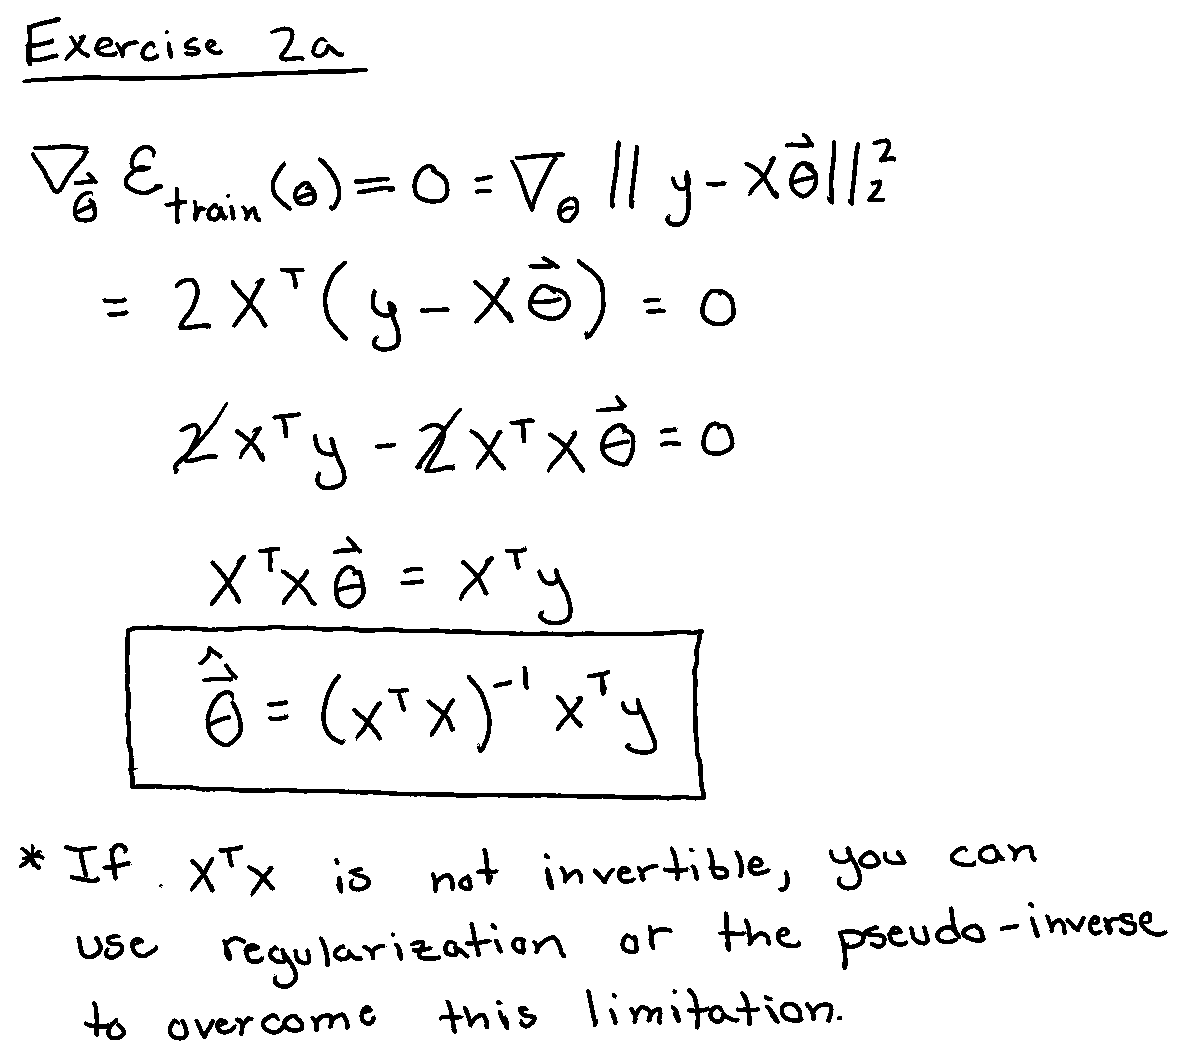

In [61]:
display(Image(filename="./images/hw2_p2a.png", height=400, width=500))

#### 2b) Optimization solution using linear algebra analytic solution

In [62]:
# Solve optimization problem using linear algebra analytic solution
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
display(Math(r"\hat{\theta} \text{ using linear algebra analytic solution:}"))
print(theta_hat)


<IPython.core.display.Math object>

[[-10.7017505 ]
 [ -0.12339677]
 [  6.67486843]]


#### 2c) Optimization solution using CVXPY

In [63]:
# Now solve the same problem using cvxpy
d = 3  # theta dimension
theta_hat = cp.Variable((d, 1))
objective = cp.Minimize(cp.sum_squares(y - X @ theta_hat))
constraints = []
prob = cp.Problem(objective, constraints)

optimal_objective_value = prob.solve()
display(Math(r"\hat{\theta} \text{ using cvxpy:}"))
# print(optimal_objective_value)
print(theta_hat.value)


<IPython.core.display.Math object>

[[-10.7017505 ]
 [ -0.12339677]
 [  6.67486843]]


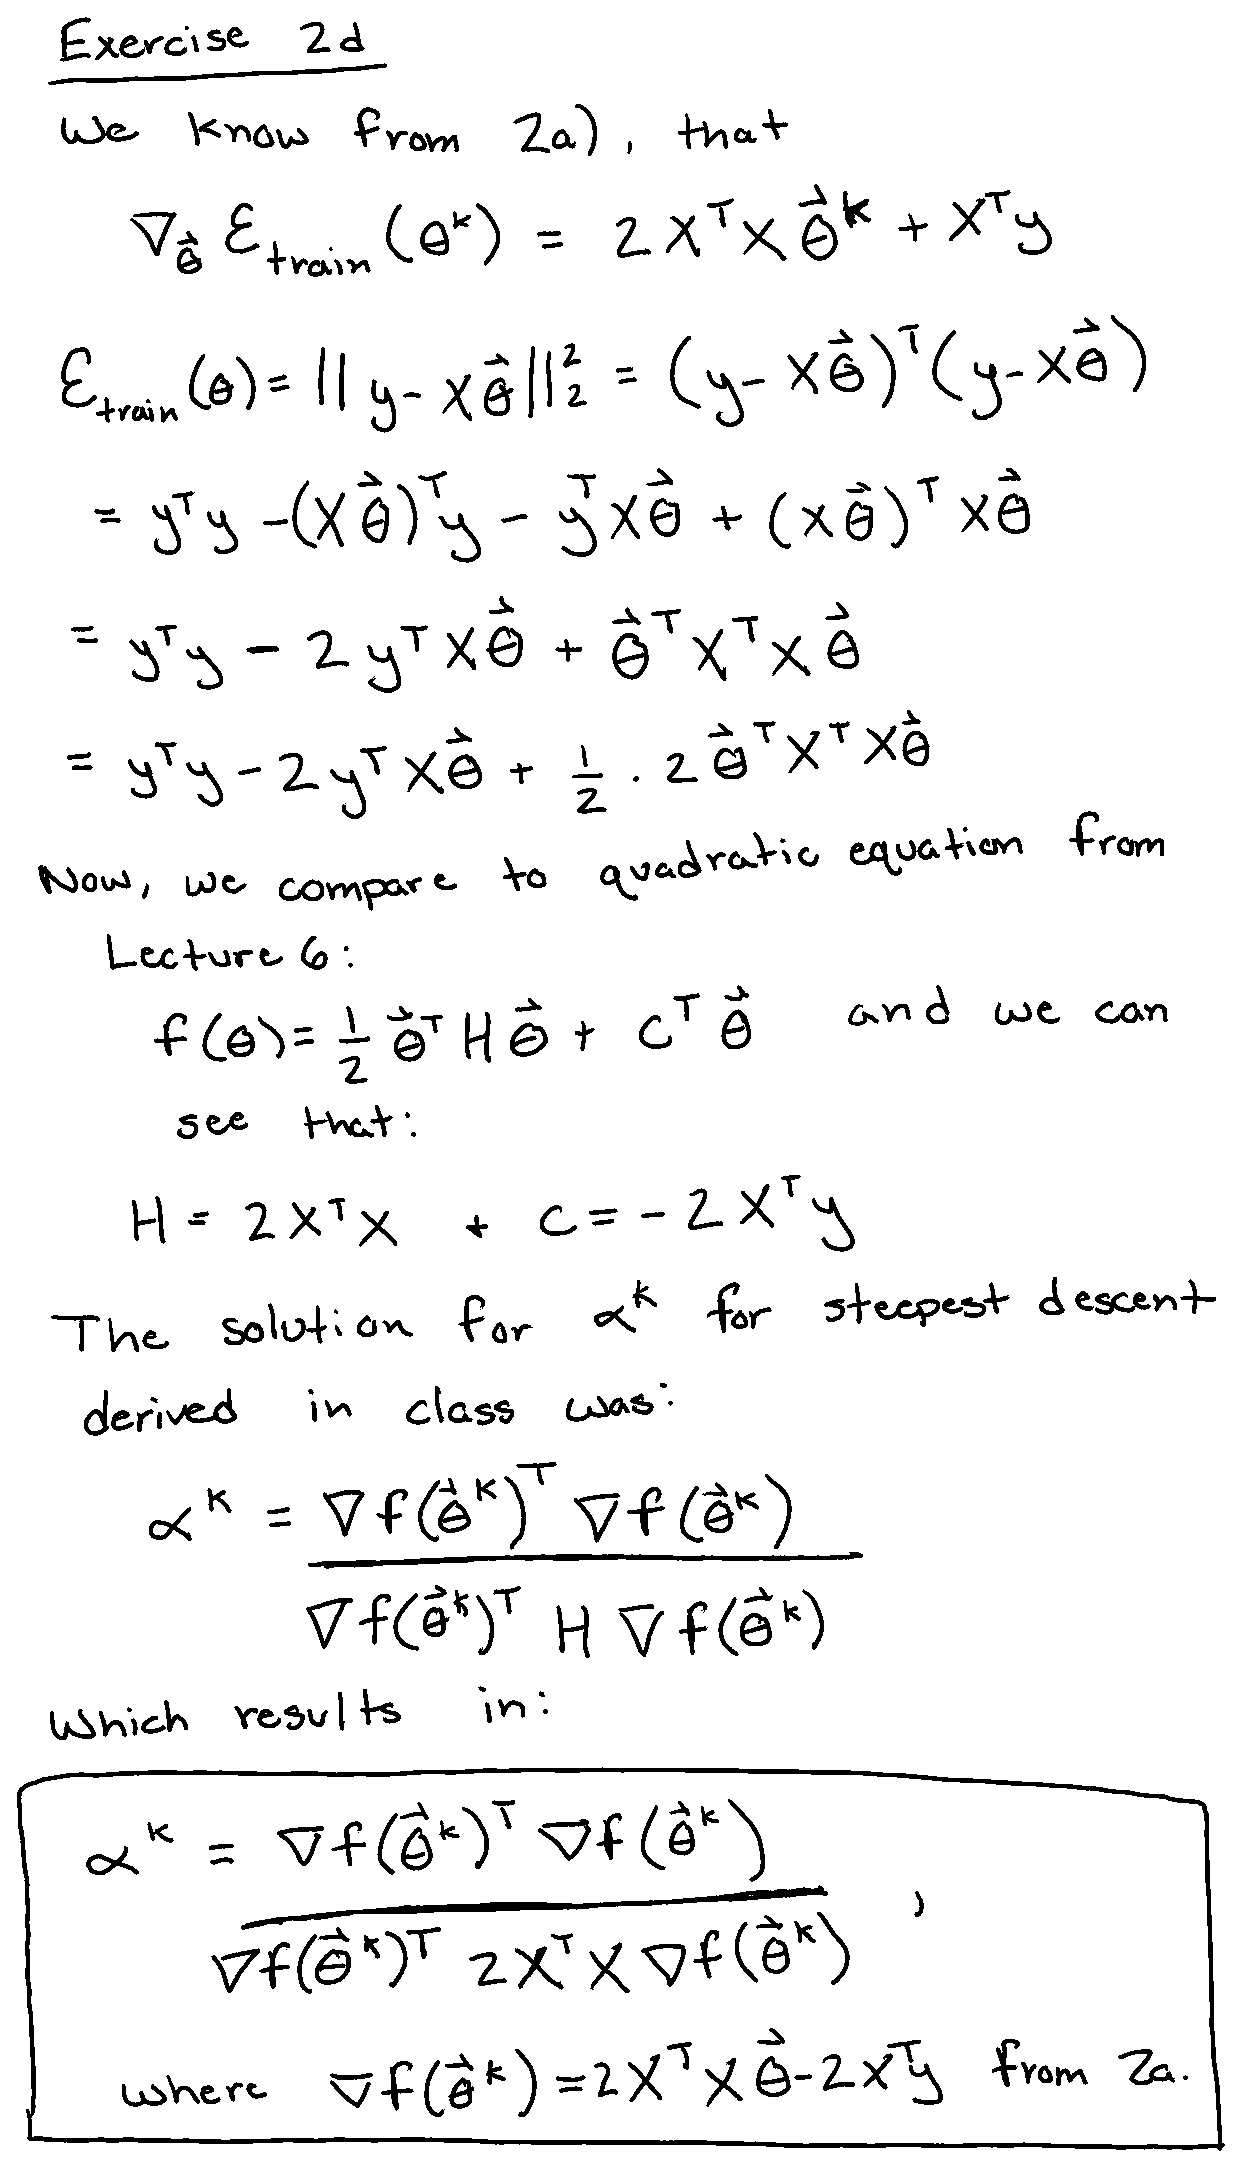

In [64]:
display(Image(filename="./images/hw2_p2d.png", height=400, width=500))

#### 2e) Gradient Descent + Exact Line Search

In [65]:
# Now solve the same problem using our homemade Gradient Descent algorithm
def gradient_descent_exact(f: Callable, f_grad: Callable, x_0: np.array,
                           H: np.matrix, num_iter=1000) -> Tuple[List[np.array], List[float]]:
    """Gradient descent method for unconstrained optimization problem.
    given a starting point x ∈ Rⁿ,
    repeat
        1. Define direction. p := −∇f(x).
        2. Line search. Choose step length α using Exact Line Search.
        3. Update. x := x + αp.
    until num iterations is satisfied.

    Parameters
    --------------------
    f: callable
        Function to be minimized.
    f_grad: callable
        The first derivative of f.
    x_0: array
        Initial value of x.
    H: 
        Exact line search denominator matrix
    max_iter : integer, optional
        maximum number of steps.
    """
    xk = x_0
    fk = f(xk)
    cur_iter = 0
    xk_array = []
    fk_array = []
    xk_array.append(xk)
    fk_array.append(fk)
    print('Initial condition: y = {:.4f}, x = {} \n'.format(fk, xk))
    while cur_iter < num_iter:
        # Calculate f'(x)
        gftk = f_grad(xk)
        # Calculate alpha using exact line equation
        alpha = (gftk.T @ gftk) / (gftk.T @ H @ gftk)
        # Update xk
        xk = xk - alpha * gftk
        # Increase number of steps by 1
        cur_iter += 1
        # print('Iteration: {} \t y = {:.4f}, x = {}'.
        #       format(cur_iter, f(xk), xk))
        xk_array.append(xk)
        fk_array.append(f(xk))
    # Return results
    return (xk_array, fk_array)


def f_theta(theta):
    # From definition
    return np.linalg.norm(y - X @ theta, 2)


def f_theta_grad(theta):
    # From lecture 1 derivation
    # return 2 * (X.T @ X @ theta - X.T @ y) # What happened to the 2?
    return 2 * (X.T @ X @ theta - X.T @ y)


theta_0 = np.array([0.0, 0.0, 0.0]).reshape((3, 1))

xks, fks = gradient_descent_exact(f_theta, f_theta_grad, theta_0,
                                  H=2 * X.T @ X, num_iter=50000)
display(Math(r"\hat{\theta} \text{ using gradient descent:}"))
print(xks[-1])


Initial condition: y = 56.7803, x = [[0.]
 [0.]
 [0.]] 



<IPython.core.display.Math object>

[[-10.7017505 ]
 [ -0.12339677]
 [  6.67486843]]


#### 2f) Gradient Descent + Exact Line Search Training Loss Plot

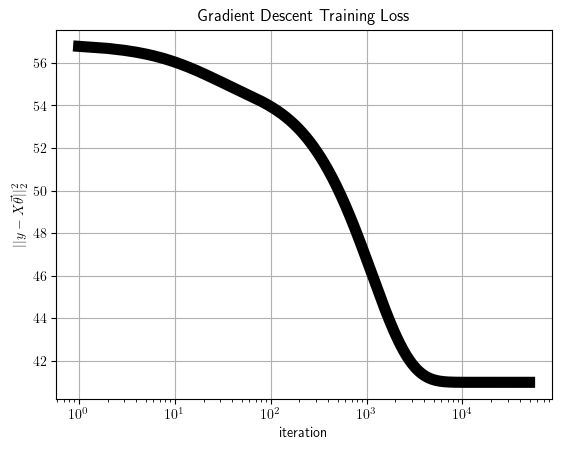

In [66]:
# Plot training loss
fig = plt.figure()
x = np.linspace(1, len(xks), len(xks))
plt.semilogx(x, fks, c="k", linewidth=8)
plt.title('Gradient Descent Training Loss')
plt.grid(visible=True)
plt.xlabel("iteration")
plt.ylabel(r"$||y - X \vec{\theta}||_2^2$")
plt.show()


#### 2g) Gradient Descent + Momentum Method

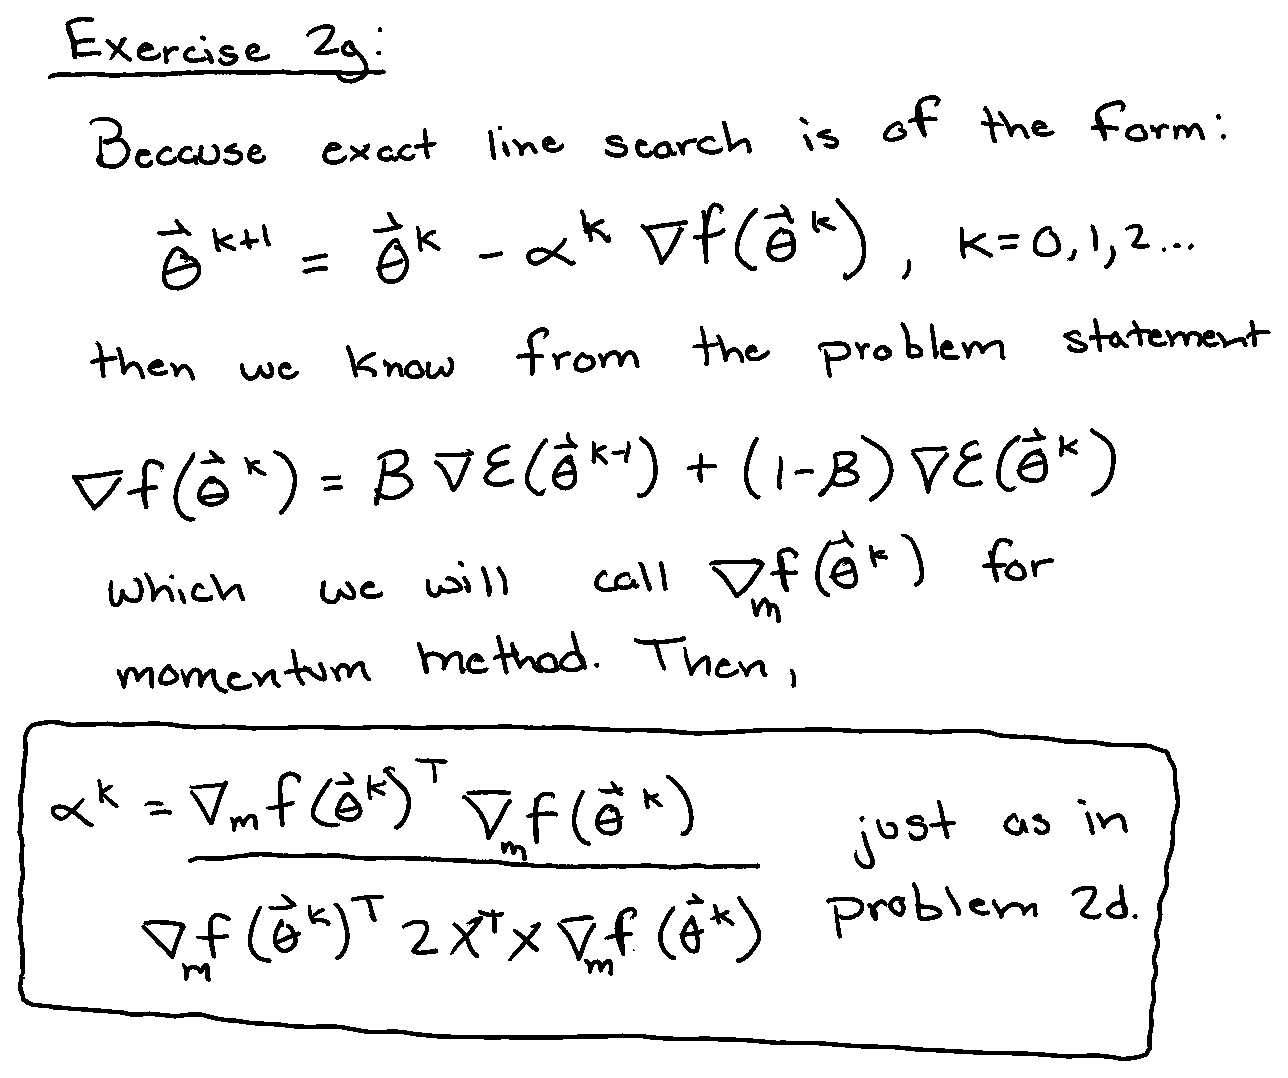

In [67]:
display(Image(filename="./images/hw2_p2g.png", height=400, width=500))

In [68]:
# Now solve the same problem using our homemade Gradient Descent momentum algorithm
def gradient_descent_exact_momentum(f: Callable, f_grad: Callable, x_0: np.array,
                                    H: np.matrix, beta=0.9, num_iter=1000) -> Tuple[List[np.array], List[float]]:
    """Gradient descent method for unconstrained optimization problem.
    given a starting point x ∈ Rⁿ,
    repeat
        1. Define direction. p := −∇f(x).
        2. Line search. Choose step length α using Exact Line Search.
        3. Update. x := x + αp.
    until num iterations is satisfied.

    Parameters
    --------------------
    f: callable
        Function to be minimized.
    f_grad: callable
        The first derivative of f.
    x_0: array
        Initial value of x.
    H: 
        Exact line search denominator matrix
    beta:
        Momentum method coefficient
    max_iter : integer, optional
        maximum number of steps.
    """
    xk = x_0
    xk_1 = x_0  # Previous step
    fk = f(xk)
    cur_iter = 0
    xk_array = []
    fk_array = []
    xk_array.append(xk)
    fk_array.append(fk)
    print('Initial condition: y = {:.4f}, x = {} \n'.format(fk, xk))
    while cur_iter < num_iter:
        # Store prev xk
        xk_prev = xk
        # Calculate f'(x^{k-1}) and f'(x^k)
        gftk_1 = f_grad(xk_1)
        gftk = f_grad(xk)
        mgf = (beta * gftk_1 + (1 - beta) * gftk)
        # Calculate alpha using exact line equation
        alpha = (mgf.T @ mgf) / (mgf.T @ H @ mgf)
        # Update xk
        xk = xk - alpha * mgf
        # Increase number of steps by 1
        cur_iter += 1
        # Update previous
        xk_1 = xk_prev
        # print('Iteration: {} \t y = {:.4f}, x = {}'.
        #       format(cur_iter, f(xk), xk))
        xk_array.append(xk)
        fk_array.append(f(xk))
    # Return results
    return (xk_array, fk_array)


theta_0 = np.array([0.0, 0.0, 0.0]).reshape((3, 1))

xks_m, fks_m = gradient_descent_exact_momentum(f_theta, f_theta_grad, theta_0,
                                               H=2 * X.T @ X, beta=0.9, num_iter=50000)
display(Math(r"\hat{\theta} \text{ using momentum gradient descent:}"))
print(xks_m[-1])


Initial condition: y = 56.7803, x = [[0.]
 [0.]
 [0.]] 



<IPython.core.display.Math object>

[[-10.70174617]
 [ -0.12339686]
 [  6.67486597]]


#### 2h) Gradient Descent + Momentum Method Training Loss Plot

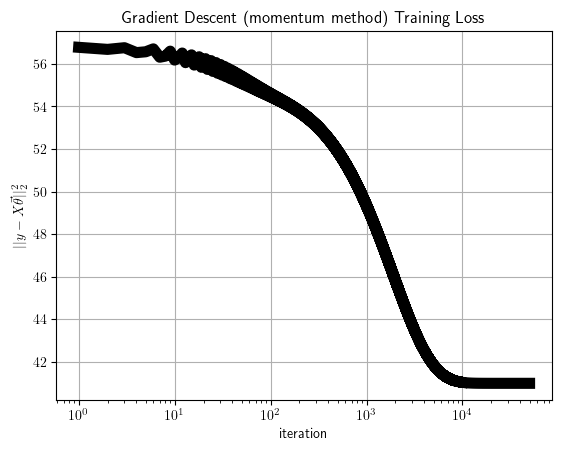

In [69]:
# Plot momentum method training loss
fig = plt.figure()
x = np.linspace(1, len(xks_m), len(xks_m))
plt.semilogx(x, fks_m, c="k", linewidth=8)
plt.title('Gradient Descent (momentum method) Training Loss')
plt.grid(visible=True)
plt.xlabel("iteration")
plt.ylabel(r"$||y - X \vec{\theta}||_2^2$")
plt.show()


## Exercise 3: Visualization and Testing


#### 3a) Scatter Plot of data + decision boundary

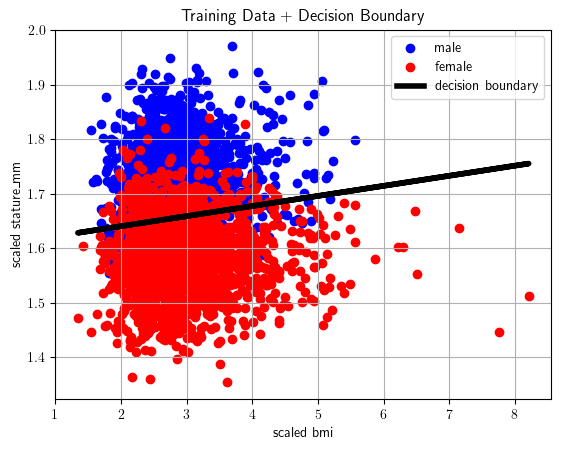

In [70]:
# Organize the data in a pandas dataframe since it is easier to work with
# Order here is the same order used to minimize the objective function above
df = pd.DataFrame(
    data={"label": y[:, 0], "bmi": data[:, 0], "stature": data[:, 1]})

# Calculate the decision boundary g_theta
x1 = data[:, 0]
theta = theta_hat.value
g_theta = -theta[0] / theta[2] - (theta[1] / theta[2]) * df.bmi

# Plot the data as a scatter plot + decision boundary
# Color female/male data separately
male_idx = df["label"] == 1
female_idx = ~male_idx
fig = plt.figure()
plt.scatter(x=df.loc[male_idx].bmi, y=df.loc[male_idx].stature, c="#0000ff")
plt.scatter(x=df.loc[female_idx].bmi, y=df.loc[female_idx].stature, c="#ff0000")
plt.plot(df.bmi, g_theta, c="k", linewidth=4)
plt.legend(["male", "female", "decision boundary"])
plt.title('Training Data + Decision Boundary')
plt.grid(visible=True)
plt.xlabel('scaled bmi')
plt.ylabel('scaled stature_mm')
plt.show()


#### 3b) Classification Accuracy (Precision + Recall)

In [71]:
# Read the test data into a Pandas dataframe
male_test, female_test = read_data(type="test", print_data=False)
male_test["label"] = 1
female_test["label"] = -1
male_test.rename(columns={"male_bmi": "bmi",
                 "male_stature_mm": "stature"}, inplace=True)
female_test.rename(columns={"female_bmi": "bmi",
                   "female_stature_mm": "stature"}, inplace=True)
df = pd.concat([male_test, female_test], ignore_index=True)

# Make the predictions
df["prediction"] = np.sign(theta[0] + theta[1] *
                           df.bmi + theta[2] * df.stature).astype(int)
# print(df.head())
# print(df.tail())

# Get the total number of row in test data set
total_samples = df.shape[0]

# Calculate Type 1 error (number of females classified as males)
df["type_1_error"] = np.logical_and(df["label"] == -1, df["prediction"] == 1)
male_fp = df["type_1_error"].values.sum()
type_1_error = male_fp / total_samples

# Calculate Type 2 error (number of males classified as females)
df["type_2_error"] = np.logical_and(df["label"] == 1, df["prediction"] == -1)
female_fp = df["type_2_error"].values.sum()
type_2_error = female_fp / total_samples

print(f"Type 1 Error: {round(type_1_error * 100, 2)}%")
print(f"Type 2 Error: {round(type_2_error * 100, 2)}%")

male_tp = np.logical_and(df["prediction"] == 1, df["label"] == 1).sum()
male_fn = np.logical_and(df["prediction"] == -1, df["label"] == 1).sum()
male_precision = round(male_tp / (male_tp + male_fp), 2)
male_recall = round(male_tp / (male_tp + male_fn), 2)
print(f"Male, precision: {male_precision}, recall: {male_recall}")

female_tp = np.logical_and(df["prediction"] == -1, df["label"] == -1).sum()
female_fn = np.logical_and(df["prediction"] == 1, df["label"] == -1).sum()
female_precision = round(female_tp / (female_tp + female_fp), 2)
female_recall = round(female_tp / (female_tp + female_fn), 2)
print(f"Female, precision: {female_precision}, recall: {female_recall}")


Type 1 Error: 7.09%
Type 2 Error: 8.98%
Male, precision: 0.85, recall: 0.82
Female, precision: 0.83, recall: 0.86


## Exercise 4: Regularization

#### 4a) Plotting

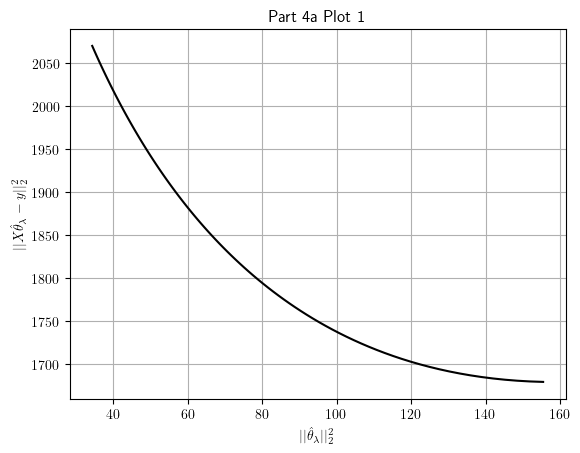

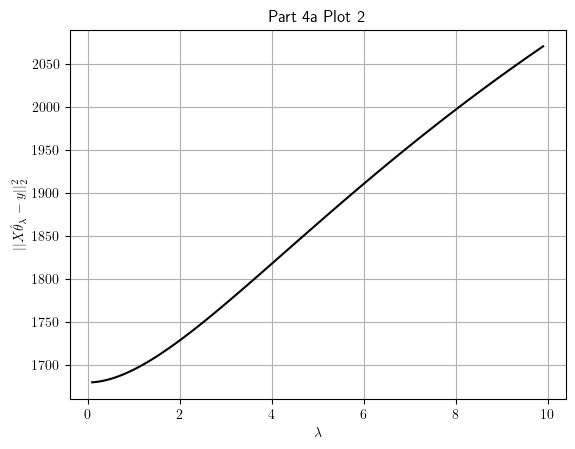

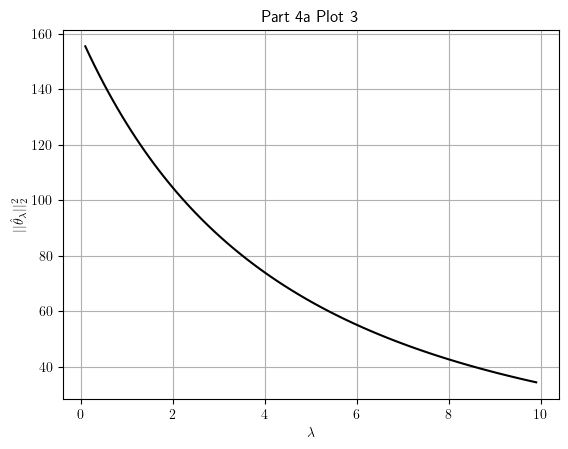

In [72]:
lambd = np.arange(0.1, 10, 0.1)

# Define optimization problem in terms of cvxpy
d = 3  # theta dimension
theta = cp.Variable((d, 1))
constraints = []

theta_lambda_hats = []

# For each lambda, use cvxpy to solve for theta_lambda
for lam in lambd:
    objective = cp.Minimize(cp.sum_squares(X @ theta - y) + lam * cp.sum_squares(theta))
    prob = cp.Problem(objective, constraints)
    optimal_objective_value = prob.solve()
    theta_lambda_hat = theta.value
    theta_lambda_hats.append(theta_lambda_hat)

# Generate a few different plots
plt_x = np.square(np.linalg.norm(theta_lambda_hats, 2, axis=1))
plt_y = [(X @ tlh - y) for tlh in theta_lambda_hats]
plt_y = np.square(np.linalg.norm(plt_y, 2, axis=1))
fig = plt.figure()
plt.plot(plt_x, plt_y, c="k")
plt.grid(visible=True)
plt.title("Part 4a Plot 1")
plt.xlabel(r"$||\hat{\theta}_\lambda||_2^2$")
plt.ylabel(r"$||X \hat{\theta}_\lambda-y||_2^2$")
plt.show()

plt_x = lambd
plt_y = [(X @ tlh - y) for tlh in theta_lambda_hats]
plt_y = np.square(np.linalg.norm(plt_y, 2, axis=1))
fig = plt.figure()
plt.plot(plt_x, plt_y, c="k")
plt.grid(visible=True)
plt.title("Part 4a Plot 2")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||X \hat{\theta}_\lambda-y||_2^2$")
plt.show()

plt_x = lambd
plt_y = np.square(np.linalg.norm(theta_lambda_hats, 2, axis=1))
fig = plt.figure()
plt.plot(plt_x, plt_y, c="k")
plt.grid(visible=True)
plt.title("Part 4a Plot 3")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||\hat{\theta}_\lambda||_2^2$")
plt.show()

#### 4b) Equivalence

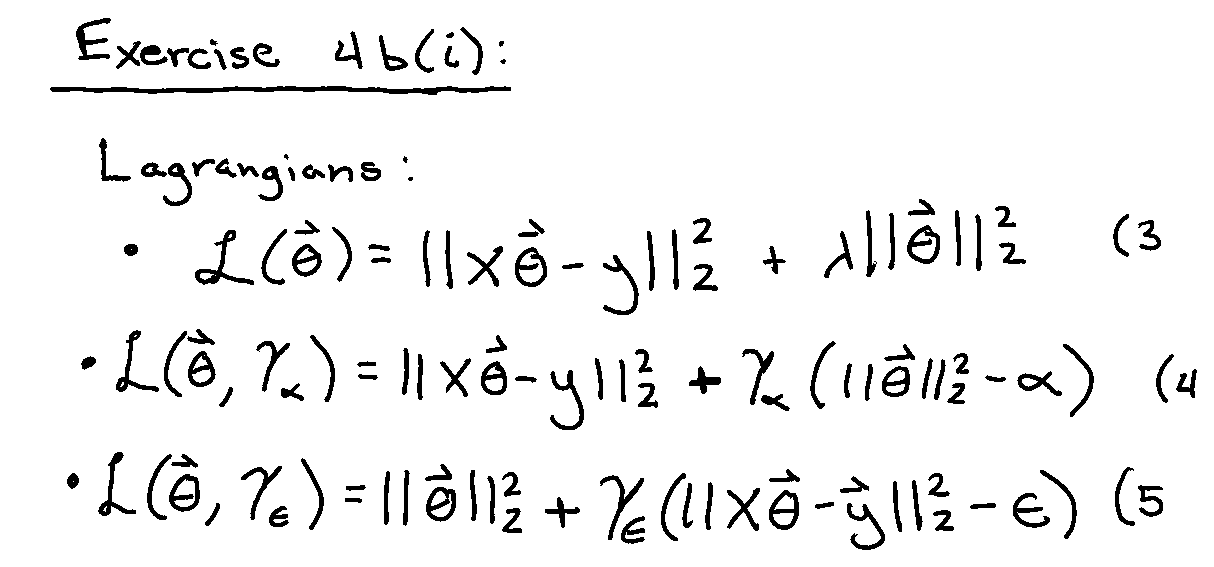

In [73]:
display(Image(filename="./images/hw2_p4bi.png", height=400, width=500))

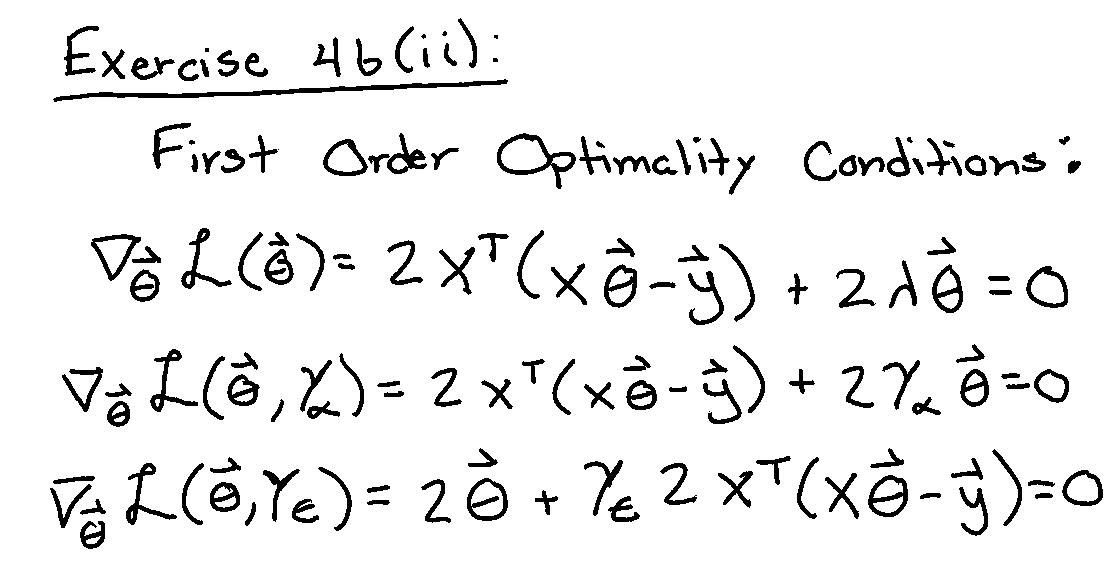

In [74]:
display(Image(filename="./images/hw2_p4bii.png", height=400, width=500))

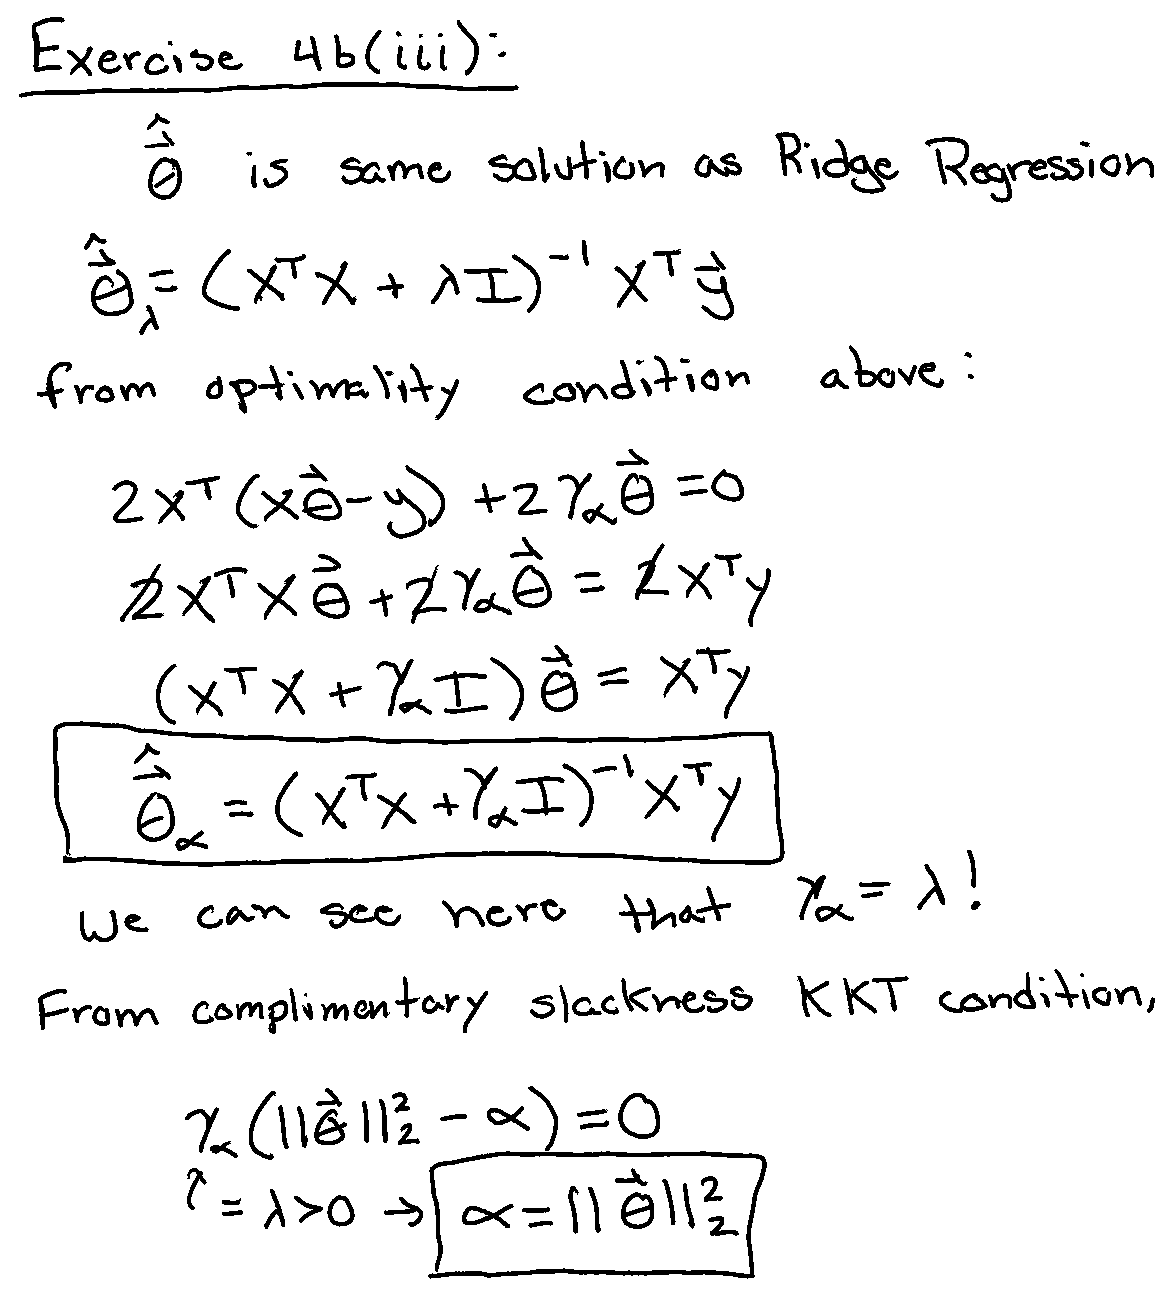

In [75]:
display(Image(filename="./images/hw2_p4biii.png", height=400, width=500))

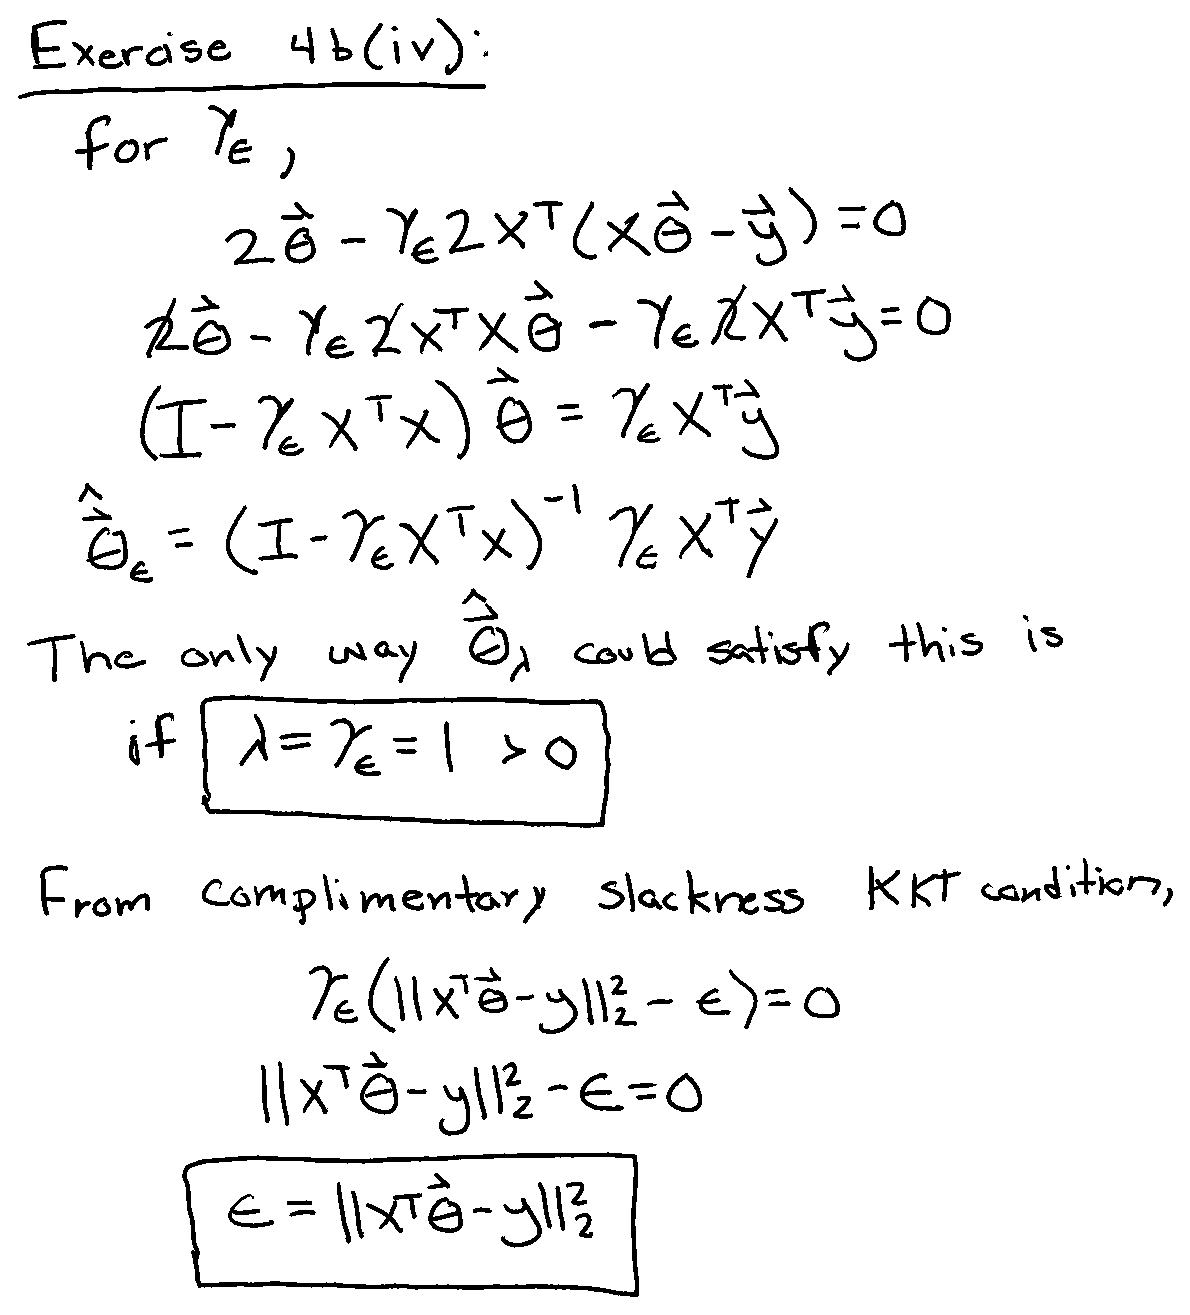

In [76]:
display(Image(filename="./images/hw2_p4biv.png", height=400, width=500))

##### 4bv):
The analysis in part iii is ot enough to claim that $\hat{\vec{\theta}}_\lambda$ is the solution of iv. We must also show that the objective function and constraints of iii and iv ar convex. Otherwise, there may be multiple feasible regions with multiple locally optimal solutions within each region and $\hat{\vec{\theta}}_\lambda$ would not be guaranteed to be the global solution to iv.

### Exercise 5: Project Checkpoint 2

Project Summary:

"Practical bayesian optimization of machine learning algorithms" address problem of selecting and tuning the hyperparameters associated with different machine learning algorithms. The paper takes a bayesian optimization approach to determine the hyperparameters as if the underlying machine learning algorithm is a black box and assumes a gaussian distribution for the underlying function evaluations. This is an important problems because there are many machine learning algorithms being used in practice and these algorithms usually have hyperparameters that are not obvious as to what they should be set to. This paper prevents the user from having to tune/experiment with as many "knobs". The innovations in this paper include modeling cost (in units of $), ensuring optimization algorithms make use of now commonplace multi-core compute architectures and using Monte Carlo estimation methods to implement the optimization parallelism. The paper mentions that the code is publicly available and the underlying machine learning algorithms they are optimizing over are quoted as common algorithms. I am going to start looking at their implementation of the optimization of the logistic regression ML algorithm since that is closest to what we have covered in class. There are multiple black box ML algorithms used in this paper that I am not familiar with (e.g. Branin-Hoo, Online LDA and Motif Finding with SVM), also, I want to refresh my knowledge of Bayesian methods (we are covering some of this in class).